<a href="https://colab.research.google.com/github/NoeZGravity/IS403.N21.HTTT-Nhom9/blob/20521720---Truong-Y-Nhi/TIMEGAN_TW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
import matplotlib.dates as mdates


In [2]:
df=pd.read_csv('/content/2357.TW.csv')

In [3]:
# Checking null value
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,273.5,281.5,265.0,279.5,187.362213,19125460
1,2018-01-01,279.5,284.0,258.5,281.0,188.367722,31418764
2,2018-02-01,279.0,283.0,265.0,277.0,185.686340,26526226
3,2018-03-01,272.5,301.5,262.0,276.0,185.015991,24939731
4,2018-04-01,277.0,282.0,272.0,278.0,186.356689,18566766
5,2018-05-01,278.0,280.5,271.5,271.5,181.999420,29947856
6,2018-06-01,272.0,283.0,272.0,278.5,186.691864,25919314
7,2018-07-01,276.0,277.5,251.0,263.5,176.636642,37873563
8,2018-08-01,264.5,271.0,239.5,261.5,185.487579,32888463
9,2018-09-01,262.5,264.0,248.5,264.0,187.260880,18166654


In [6]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%Y/%m/%d')
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Close'] = df['Close'].astype(str).apply(lambda x: float(x.replace(',', '')))



In [7]:
tranformData(df)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,273.5,281.5,265.0,279.5,187.362213,19125460
1,2018-01-01,279.5,284.0,258.5,281.0,188.367722,31418764
2,2018-02-01,279.0,283.0,265.0,277.0,185.686340,26526226
3,2018-03-01,272.5,301.5,262.0,276.0,185.015991,24939731
4,2018-04-01,277.0,282.0,272.0,278.0,186.356689,18566766
...,...,...,...,...,...,...,...
59,2022-11-01,236.0,271.5,229.5,266.0,266.000000,63037099
60,2022-12-01,270.0,283.0,261.5,268.5,268.500000,69152509
61,2023-01-01,267.0,280.5,263.5,272.0,272.000000,20905266
62,2023-02-01,274.5,282.0,270.0,278.0,278.000000,26861610


In [8]:
df=df.set_index('Date')
df = df.sort_index()
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,273.5,281.5,265.0,279.5,187.362213,19125460
2018-01-01,279.5,284.0,258.5,281.0,188.367722,31418764
2018-02-01,279.0,283.0,265.0,277.0,185.686340,26526226
2018-03-01,272.5,301.5,262.0,276.0,185.015991,24939731
2018-04-01,277.0,282.0,272.0,278.0,186.356689,18566766
...,...,...,...,...,...,...
2022-11-01,236.0,271.5,229.5,266.0,266.000000,63037099
2022-12-01,270.0,283.0,261.5,268.5,268.500000,69152509
2023-01-01,267.0,280.5,263.5,272.0,272.000000,20905266


In [9]:
fig = px.line(df, x=df.index, y=df.Close,labels={'Date':'Date','Close':'Close'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Close Price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [10]:
def prepare_data_for_gan(df, num_steps):
    data = df.values
    data = data.reshape(-1, 1)  # Chuyển đổi dữ liệu thành ma trận 2D (số mẫu, 1)

    # Chuẩn hóa dữ liệu về khoảng [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Chia dữ liệu thành các chuỗi con có độ dài num_steps
    X = []
    for i in range(len(data) - num_steps):
        X.append(data[i:i+num_steps])

    # Chuyển đổi thành numpy array
    X = np.array(X)

    # Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
    train_size = int(len(df) * 0.7)
    test_size = int(0.2 * len(df))
    val_size = len(df) - train_size - test_size


    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    val_data = data[train_size+test_size:]

    return train_data, test_data, val_data, scaler


In [11]:
# Số lượng bước thời gian trong mỗi chuỗi con
num_steps = 5

# Chuẩn bị dữ liệu cho mô hình Time-GAN
train_data, test_data, val_data, scaler = prepare_data_for_gan(df['Close'], num_steps)

# In số lượng mẫu trong mỗi tập dữ liệu
print("Số lượng mẫu trong tập huấn luyện:", train_data.shape)
print("Số lượng mẫu trong tập kiểm tra:", test_data.shape)
print("Số lượng mẫu trong tập valid: ", val_data.shape)

Số lượng mẫu trong tập huấn luyện: (44, 1)
Số lượng mẫu trong tập kiểm tra: (12, 1)
Số lượng mẫu trong tập valid:  (8, 1)


In [12]:
def build_time_gan(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model

# Xác định input_shape
input_shape = (num_steps, 1)

# Xây dựng mô hình Time-GAN
model = build_time_gan(input_shape)

# In thông tin về mô hình
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           33792     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 5, 128)           98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                        

In [13]:
def train_time_gan(model, train_data, epochs, num_steps):
    X_train = []
    y_train = []
    for i in range(len(train_data) - num_steps):
        X_train.append(train_data[i:i+num_steps])
        y_train.append(train_data[i+num_steps])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)
    return history



# Số lượng time steps
epochs = 10

# Huấn luyện mô hình Time-GAN
history = train_time_gan(model, train_data, epochs, num_steps)


Epoch 1/10
2/2 [==============================] - 16s 25ms/step - loss: 0.1319
Epoch 2/10
2/2 [==============================] - 0s 17ms/step - loss: 0.0993
Epoch 3/10
2/2 [==============================] - 0s 15ms/step - loss: 0.0698
Epoch 4/10
2/2 [==============================] - 0s 15ms/step - loss: 0.0465
Epoch 5/10
2/2 [==============================] - 0s 16ms/step - loss: 0.0417
Epoch 6/10
2/2 [==============================] - 0s 16ms/step - loss: 0.0442
Epoch 7/10
2/2 [==============================] - 0s 16ms/step - loss: 0.0380
Epoch 8/10
2/2 [==============================] - 0s 18ms/step - loss: 0.0337
Epoch 9/10
2/2 [==============================] - 0s 15ms/step - loss: 0.0301
Epoch 10/10
2/2 [==============================] - 0s 16ms/step - loss: 0.0359


1/1 [==============================] - 0s 25ms/step
Validation RMSE: 0.16744132392359753
Testing RMSE: 0.5715724532240422
Validation MAE: 0.15939524634536684
Testing MAE: 0.5429241912315931
Validation MAPE: 0.5397661517214074
Testing MAPE: 0.7169262669083074


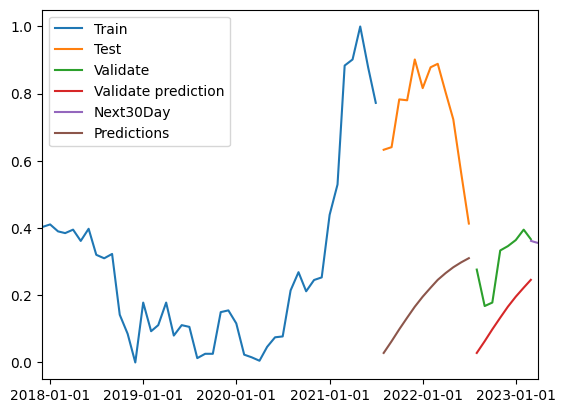

In [14]:
# Quá trình testing
x_test = np.arange(len(test_data)).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(x_test)

# Quá trình validate
x_val = np.arange(len(val_data)).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val = model.predict(x_val)

# Quá trình validate
x_val = np.arange(len(val_data)).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val = model.predict(x_val)

# Tạo dataframe dự báo cho 30 ngày tiếp theo
last_date = pd.to_datetime(df.index[-1])
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Close': np.zeros(len(forecast_dates))})

# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
x_next_30_days = np.arange(len(df), len(df) + len(forecast_df)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)

# Đưa các dự đoán vào dataframe forecast_df
forecast_df['Close'] = y_next_30_days

# Tính toán RMSE cho quá trình validate và testing
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mae = np.mean(np.abs((y_pred_val - y_val)))
test_mae = np.mean(np.abs((y_pred - y_test)))
valid_mape = np.mean(np.abs((y_pred_val - y_val)/y_val))
test_mape = np.mean(np.abs((y_pred - y_test)/y_test))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# Convert dates to a more appropriate format
dates = pd.to_datetime(df.index)

# Vẽ biểu đồ
plt.plot(dates[:len(train_data)], train_data)
plt.plot(dates[len(train_data):len(train_data)+len(test_data)], test_data)
plt.plot(dates[len(train_data)+len(test_data):len(train_data)+len(test_data)+len(val_data)], val_data)
plt.plot(dates[len(train_data)+len(test_data):len(train_data)+len(test_data)+len(val_data)], y_pred_val)
plt.plot(forecast_df.Date, forecast_df.Close)
plt.plot(dates[len(train_data):len(train_data)+len(test_data)], y_pred)

# Set x-axis range
plt.xlim(dates[0], forecast_dates[-1])

# Set x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(['Train', 'Test', 'Validate', 'Validate prediction', 'Next30Day', 'Predictions'])
plt.show()
